# Homework 1

**Name**: Dyson Lewis

**UID**: 106033522


## Preparation (download data and import packages)

In [ ]:
# Download a processed version of the data
!wget https://huggingface.co/hk/hw1/resolve/main/mushroom.txt

--2025-10-13 22:41:04--  https://huggingface.co/hk/hw1/resolve/main/mushroom.txt
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.80, 18.239.50.16, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22 [following]
--2025-10-13 22:41:04--  https://huggingface.co/api/resolve-cache/models/hk/hw1/d23e2ca56c2eb67af93a318c77348b936dcf4d12/mushroom.txt?%2Fhk%2Fhw1%2Fresolve%2Fmain%2Fmushroom.txt=&etag=%2212401d069edc9c3b8be14236a657b917ab324a19%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt’

mushroom.txt        100%[===================>]   1.21M  --.-KB/s    in 0.03s   

2025-1

In [ ]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import random
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

mpl.lines.width = 2
mpl.axes.labelsize = 14

# 3.1 Visualizing Features

In [ ]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'POISONOUS': 0, 'EDIBLE': 1}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape',
    #1 'cap-surface',
    #2 'cap-color',
    #3 'bruises',
    #4 'odor',
    #5 'gill-attachment',
    #6 'gill-spacing',
    #7 'gill-size',
    #8 'gill-color',
    #9 'stalk-shape',
    #10 'stalk-root',
    #11 'stalk-surface-above-ring',
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',
    Xnames = [
        'cap-shape',
        'cap-surface',
        'cap-color',
        'bruises',
        'odor',
        'gill-attachment',
        'gill-spacing',
        'gill-size',
        'gill-color',
        'stalk-shape',
        'stalk-root',
        'stalk-surface-above-ring',
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]
    # We only use these 6 features
    features = [0, 3, 4, 9, 11, 16]
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    print(f"Features selected: {Xnames}")
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


# Shuffle the data for cross-validation
import random
idx = list(range(n))
random.seed(0)
random.shuffle(idx)
X = np.take(X, idx, axis=0)
y = np.take(y, idx, axis=0)

Features selected: ['cap-shape', 'bruises', 'odor', 'stalk-shape', 'stalk-surface-above-ring', 'veil-color']


In [ ]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,20))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values.    # aka n rows and d columns-- so n instances and d features per instance
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels

Plotting...


<Figure size 640x480 with 0 Axes>

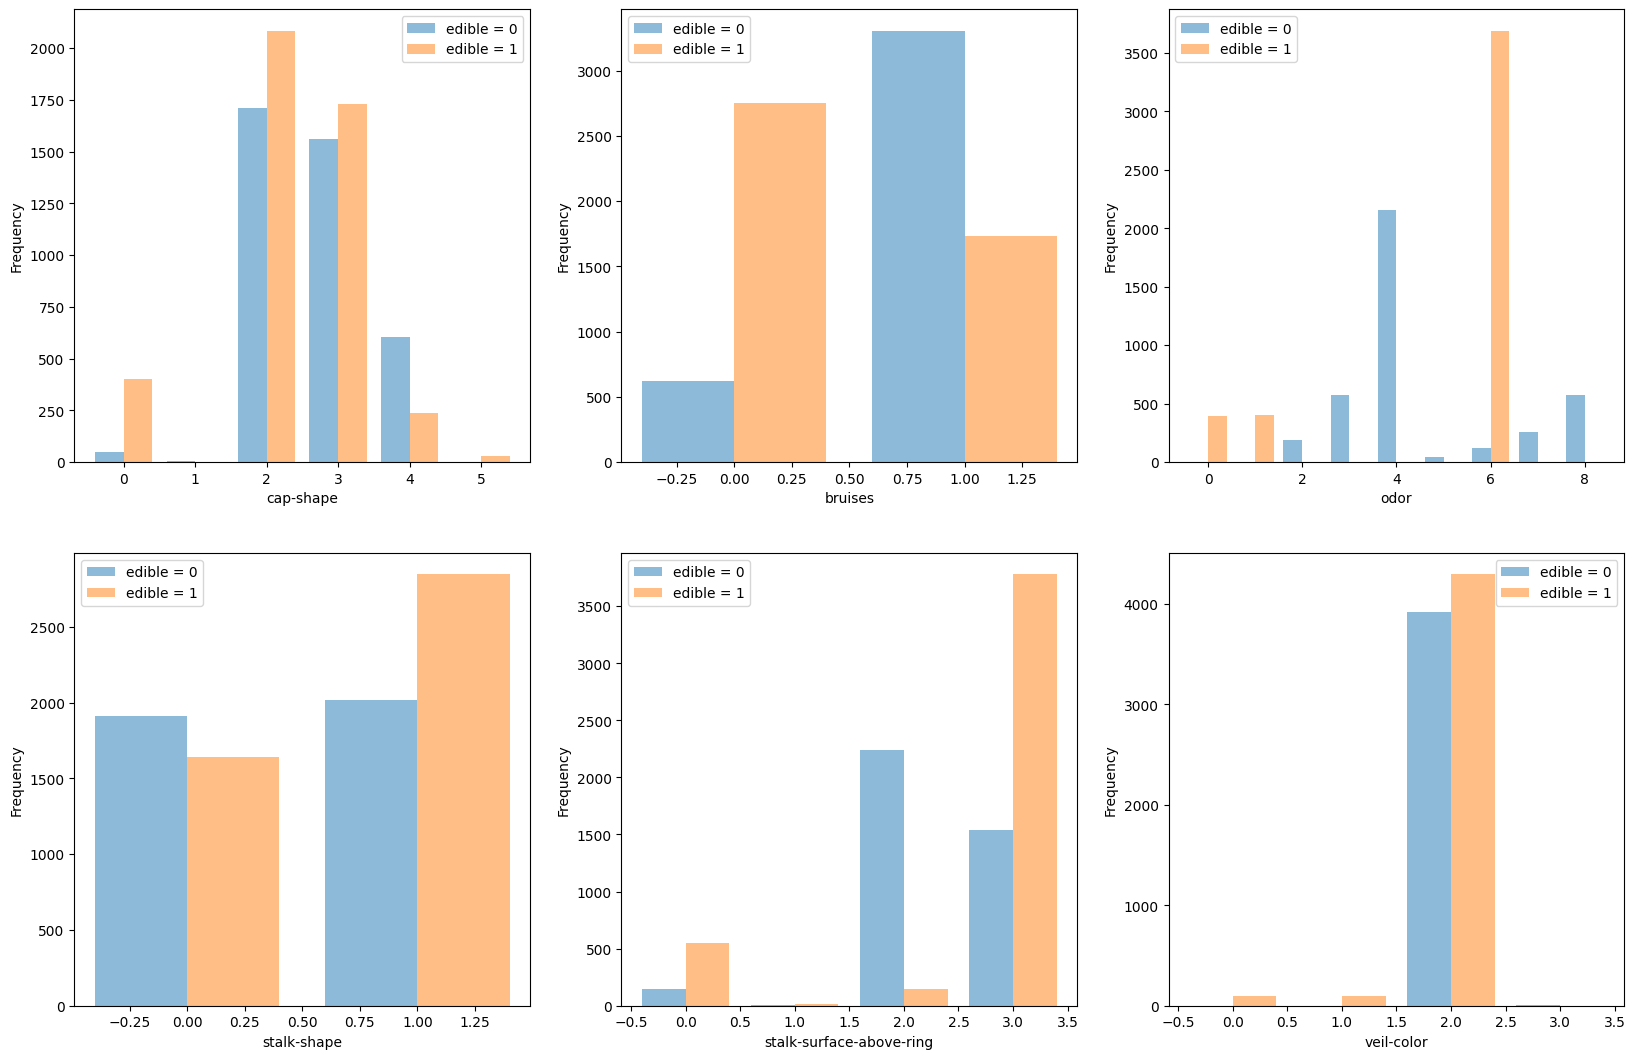

In [ ]:
plt.figure()
# Plot histograms of each feature
print('Plotting...')

plot_histograms (X, y, Xnames=Xnames, yname=yname)

# 3.2 Training and Evaluating Models

## Majority Vote Classifier

In [ ]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        # most_common(n) returns an array of the n most commmon values, where the values themselves are a (key, value_count) tuple
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n # makes an n element array, where every element is self.prediction
        return y

In [ ]:
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.467


## (a) Implement Random Classifier and Evaluate

In [ ]:
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """


        ### ========== TODO (a): START ========== ###
        # set self.probabilities_ according to the training set
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        n, d = X.shape

        ### ========== TODO (a): START ========== ###
        # predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        ### ========== TODO : END ========== ###




In [ ]:
def problem_a_solution():
    """
    Initialize a RandomClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error    -- float, training error of the RandomClassifier, between 0 and 1
    """
    ### ========== TODO (a): START ========== ###
    # evaluate training error of Random classifier
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes. Any changes will be overwritten.
# ==============================================================================

print(f'PROBLEM_A_ANSWER: {problem_a_solution()}')

## (b) Evaluate Decision Tree Classifier

In [ ]:
def problem_b_solution():
    """
    Initialize a DecisionTreeClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error    -- float, training error of the classifier, between 0 and 1
    """
    ### ========== TODO (b): START ========== ###
    # evaluate training error of Decision Tree classifier
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

print(f'PROBLEM_B_RESPONSE: {problem_b_solution()}')

## (c) Evaluate KNN Classifier

In [ ]:
def problem_c_solution():
    """
    Initialize a KNeighborsClassifier and evaluate its training error on X and y.

    Returns
    --------------------
        error_1    -- float, training error of the classifier when k=3, between 0 and 1
        error_2    -- float, training error of the classifier when k=7, between 0 and 1
        error_3    -- float, training error of the classifier when k=21, between 0 and 1

    """
    ### ========== TODO (c): START ========== ###
    # evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 7, 21 for n_neighbors
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

error_1, error_2, error_3 = problem_c_solution()

print(f'PROBLEM_C_RESPONSE_1: {error_1}')
print(f'PROBLEM_C_RESPONSE_2: {error_2}')
print(f'PROBLEM_C_RESPONSE_3: {error_3}')

## (d) Define the `error()` Function and Evaluate

In [ ]:
def error(clf, X, y, ntrials=1, test_size=0.0) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO (d): START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    ### ========== TODO : END ========== ###


In [ ]:
def problem_d_solution():
    """
    Incur the error() function on the four classifiers, and report their f1 scores.
    Use 'ntrials=100' and 'test_size=0.10'.

    Returns
    --------------------
        f1_score_1    -- float, f1 score of MajorityVoteClassifier, between 0 and 1
        f1_score_2    -- float, f1 score of RandomClassifier, between 0 and 1
        f1_score_3    -- float, f1 score of DecisionTreeClassifier (use criterion='entropy'), between 0 and 1
        f1_score_4    -- float, f1 score of KNeighborsClassifier (use 'n_neighbors=7'), between 0 and 1
    """
    ### ========== TODO (d): START ========== ###
    # use cross-validation to compute average training and test error of classifiers
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

f1_score_1, f1_score_2, f1_score_3, f1_score_4 = problem_d_solution()

print(f'PROBLEM_D_RESPONSE_1: {f1_score_1}')
print(f'PROBLEM_D_RESPONSE_2: {f1_score_2}')
print(f'PROBLEM_D_RESPONSE_3: {f1_score_3}')
print(f'PROBLEM_D_RESPONSE_4: {f1_score_4}')

## (e) Find the Best Value of K

In [ ]:
def problem_e_solution():
    """
    Use the 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier,
        and the corresponding f1 score.

    Returns
    --------------------
        best_k      -- integer, best value of k
        f1_score    -- float, f1 score of KNeighborsClassifier, between 0 and 1
    """
    ### ========== TODO (e): START ========== ###
    # use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

best_k, f1_score = problem_e_solution()

print(f'PROBLEM_E_RESPONSE_1: {best_k}')
print(f'PROBLEM_E_RESPONSE_2: {f1_score}')

In [ ]:
### ===== TODO (e) plot: START ===== ###
# plot the validation score against the number of neighbors, k
### ========== TODO : END ========== ###

## (f) Find the Best Depth

In [ ]:
def problem_f_solution():
    """
    Use the 20-fold cross-validation to find the best depth for DecisionTreeClassifier,
        and the corresponding f1 score.

    Returns
    --------------------
        best_depth      -- integer, best depth value
        f1_score    -- float, f1 score, between 0 and 1
    """
    ### ========== TODO (f): START ========== ###
    # investigate decision tree classifier with various depths
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

best_depth, f1_score = problem_f_solution()

print(f'PROBLEM_F_RESPONSE_1: {best_depth}')
print(f'PROBLEM_F_RESPONSE_2: {f1_score}')

In [ ]:
### ===== TODO (f) plot: START ===== ###
# plot the average training F1 Score and test F1 score against the depth limit
### ========== TODO : END ========== ###

## (g) Utilize the Decision Tree

In [ ]:
plt.figure(figsize=(12, 8))
### ===== TODO (g) plot: START ===== ###
# fit the DecisionTreeClassifier as required and visualize the decision tree
# use plot_tree(..., class_names=[‘POISONOUS’, ‘EDIBLE’]) to visulize the decision tree
### ========== TODO : END ========== ###

In [ ]:
def problem_g_solution():
    """
    Determine if the given example x=[0,1,6,0,0,0] is edible.

    Returns
    --------------------
        edible  -- boolean, True if the example is edible, False otherwise
    """
    ### ========== TODO (g): START ========== ###
    ### ========== TODO : END ========== ###

In [ ]:
# ==============================================================================
#  LOCKED CELL: DO NOT EDIT
# ------------------------------------------------------------------------------
# This cell is for grading purposes.
# ==============================================================================

edible = problem_g_solution()
print(f'PROBLEM_G_RESPONSE: {edible}')